A sample Model of a CNN (Convolutional Neural Network) Image Classifier

In [3]:
import torchvision
from torchvision import datasets, transforms
from torch import utils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

classes = ( 'cherry', 'strawberry', 'tomato',)
transform = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
imgdata = datasets.ImageFolder(root='traindata', transform=transform)

#   split data into train:test at 90/10
train, test = utils.data.random_split(imgdata, [3600, 450])

#   set batch size
batch_size = 4

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [44]:
#   show image fn
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
#   simple neural network
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=4, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(4 * 37* 37, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1, 4 * 37* 37)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [5]:
#   loss function/optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
#   Train CNN
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimiser.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f' [{epoch +1}, {i +1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('End Training')

End Training


In [ ]:
import os
#   Save model
PATH = os.getcwd()+'mymodel.pth'
torch.save(net.state_dict(), PATH)

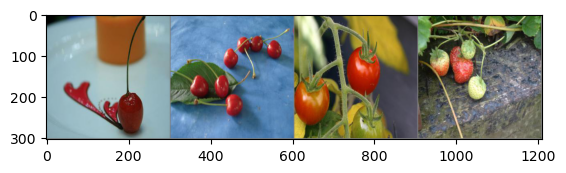

GroundTruth:  cherry cherry tomato strawberry


In [48]:
#   Test Model on Testing data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images)

In [49]:
#   Retrieve index of highest energy
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  tomato cherry tomato tomato


In [50]:
#   Testing on whole datset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1500 test images: {100 * correct // total} %')

Accuracy of the network on the 1500 test images: 47 %


In [51]:
#   Checking classes that performed well/poorly

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cherry is 47.5 %
Accuracy for class: strawberry is 7.7 %
Accuracy for class: tomato is 85.1 %
